## Displacement

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.reconstruction import EncoderDecoder
from dataset.DataReconstruction import DataReconstructionDataset
from torch.utils.data import DataLoader

/home/tingyan/.conda/envs/icshm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def visualize_masked_process_reconstructions(fig, axes, masked_signal, prediction, target_signal, task, ylabel):

    target = [1, 1, 1, 1, 0] if task == "A" else [1, 1, 0, 0, 0]

    for id, m in enumerate(masked_signal):
        mask = []
        for row in range(5):
            unique = np.unique(m[row, :])
            if len(unique) == 1 and unique[0] == 0:
                mask.append(0)
            else:
                mask.append(1)
        if target == mask:
            break

    bs, num, length = target_signal.shape
    start = 0
    length = 200

    for i in range(num):
        if len(np.unique(masked_signal[id, i, :])) != 1:
            line1 = axes[i].plot(range(len(target_signal[id, i, start:start+length])), target_signal[id, i, start:start+length], color="tab:orange",  label="Original Signal")
            line2 = axes[i].plot(range(len(prediction[id, i, start:start+length])), prediction[id, i, start:start+length], color="tab:green", linestyle="--",  label="Reconstruction Signal")          
        else:
            line3 = axes[i].plot(range(len(target_signal[id, i, start:start+length])), target_signal[id, i, start:start+length], color="tab:blue",  label="Original Signal (Masked)")
            line4 = axes[i].plot(range(len(prediction[id, i, start:start+length])), prediction[id, i, start:start+length], color="tab:red", linestyle="--",  label="Reconstruction Signal  (Masked)") 
        

    axes[0].set_title(f"Scenario {task}")
    fig.legend(handles =[line1[0], line2[0], line3[0], line4[0]], loc ='lower center', ncol=4)

In [8]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [9]:
mode = "test"
source = "Displacement"
dataset = DataReconstructionDataset(path="./Data", source=source, mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
scratch = EncoderDecoder(source=source, transfer=False, pretrain=False).eval().to("cuda")
scratch.load_state_dict(torch.load("./Logs/Reconstruction/Displacement-From_Scratch/LAST/version_0/checkpoints/epoch=00176-val_loss=0.0008.ckpt")["state_dict"])
pretrain = EncoderDecoder(source=source, transfer=False, pretrain=True).eval().to("cuda")
pretrain.load_state_dict(torch.load("./Logs/Reconstruction/Displacement-Pretrain/LAST/version_0/checkpoints/epoch=00070-val_loss=0.0007.ckpt")["state_dict"])
transfer = EncoderDecoder(source=source, transfer=True, pretrain=False).eval().to("cuda")
transfer.load_state_dict(torch.load("./Logs/Reconstruction/Displacement-Transfer/LAST/version_0/checkpoints/epoch=00494-val_loss=0.0010.ckpt")["state_dict"])

<All keys matched successfully>

In [11]:
original_signal = []
masked_signal = []

scratch_prediction = []
pretrain_prediction = []
transfer_prediction = []

for masked_input, original_input in dataloader:
    with torch.no_grad():
        masked_input = masked_input.to("cuda")       
        scratch_prediction += scratch(masked_input).unsqueeze(0)
        pretrain_prediction += pretrain(masked_input).unsqueeze(0)
        transfer_prediction += transfer(masked_input).unsqueeze(0)

        original_signal += original_input.unsqueeze(0)
        masked_signal += masked_input.unsqueeze(0)


masked_signal = torch.concat(masked_signal).cpu()
original_signal = torch.concat(original_signal).cpu()
scratch_prediction = torch.concat(scratch_prediction).cpu()
pretrain_prediction = torch.concat(pretrain_prediction).cpu()
transfer_prediction = torch.concat(transfer_prediction).cpu()

In [12]:
original_signal = denormalize(original_signal)
scratch_prediction = denormalize(scratch_prediction)
pretrain_prediction = denormalize(pretrain_prediction)
transfer_prediction = denormalize(transfer_prediction)

In [13]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_scratch = mean_squared_error(original_signal, scratch_prediction)
mse_pretrain = mean_squared_error(original_signal, pretrain_prediction)
mse_transfer = mean_squared_error(original_signal, transfer_prediction)
print(f"MSE from scrtach: {mse_scratch:.3E}")
print(f"MSE from Pretrain AE: {mse_pretrain:.3E}")
print(f"MSE from Transfer AE: {mse_transfer:.3E}")

rmse_scratch = torch.sqrt(mse_scratch)
rmse_pretrain = torch.sqrt(mse_pretrain)
rmse_transfer = torch.sqrt(mse_transfer)

print(f"RMSE from scrtach: {rmse_scratch:.3E}")
print(f"RMSE from Pretrain AE: {rmse_pretrain:.3E}")
print(f"RMSE from Transfer AE: {rmse_transfer:.3E}")

nrmse_scratch = rmse_scratch / (original_signal.max() - original_signal.min())
nrmse_pretrain = rmse_pretrain / (original_signal.max() - original_signal.min())
nrmse_transfer = rmse_transfer / (original_signal.max() - original_signal.min())

print(f"NRMSE from scrtach: {nrmse_scratch*100:.2f} %")
print(f"NRMSE from Pretrain AE: {nrmse_pretrain*100:.2f} %")
print(f"NRMSE from Trasnfer AE: {nrmse_transfer*100:.2f} %")

MSE from scrtach: 3.328E-04
MSE from Pretrain AE: 2.930E-04
MSE from Transfer AE: 4.031E-04
RMSE from scrtach: 1.824E-02
RMSE from Pretrain AE: 1.712E-02
RMSE from Transfer AE: 2.008E-02
NRMSE from scrtach: 2.40 %
NRMSE from Pretrain AE: 2.26 %
NRMSE from Trasnfer AE: 2.65 %


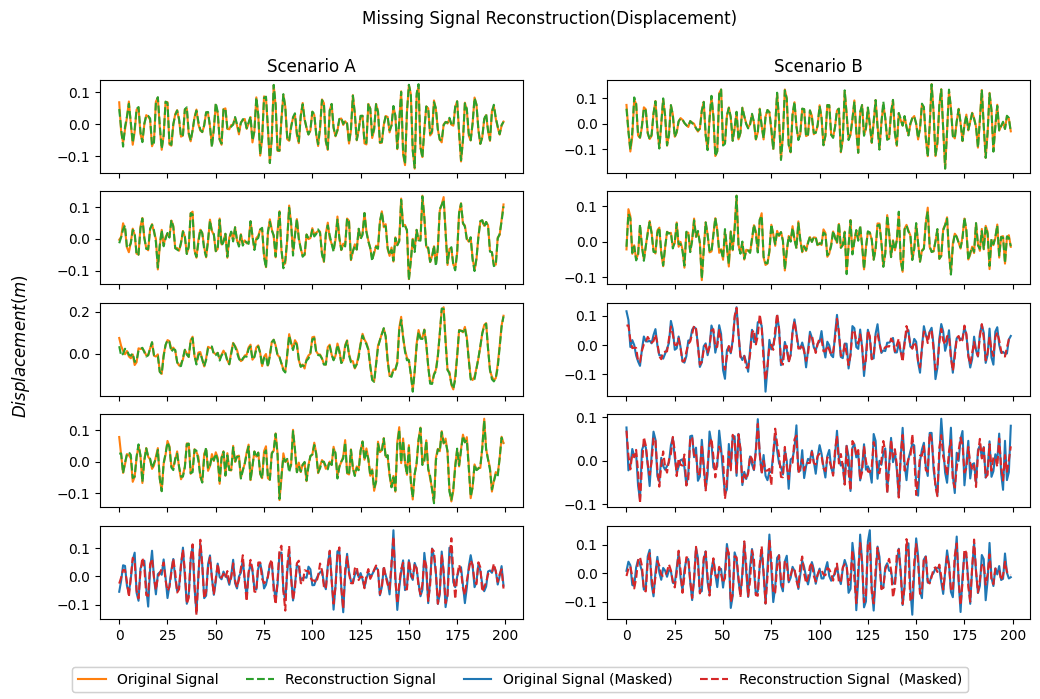

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(12,7), sharex=True)
visualize_masked_process_reconstructions(fig, axes[:,0], masked_signal, pretrain_prediction, original_signal, "A", r"$Displacement (m)$")
visualize_masked_process_reconstructions(fig, axes[:,1], masked_signal, pretrain_prediction, original_signal, "B", r"$Displacement (m)$")

fig.suptitle("Missing Signal Reconstruction(Displacement)")
fig.supylabel(r"$Displacement (m)$", x=0.05)

plt.savefig("./pic/Missing Reconstruction(disp).svg", bbox_inches="tight")
plt.savefig("./pic/Missing Reconstruction(disp).png", bbox_inches="tight", dpi=500)

## Acceleration

In [15]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.reconstruction import EncoderDecoder
from dataset.DataReconstruction import DataReconstructionDataset
from torch.utils.data import DataLoader

In [16]:
def denormalize(signal):
    min_max = pd.read_csv("./Data/Acceleration/min_max.csv").values
    n = signal.shape[0]
    output_signal = torch.zeros_like(signal, dtype=torch.float32)
    for i in range(n):
        for j in range(5):
            output_signal[i, j, :] = signal[i, j, :] * (min_max[j][1] - min_max[j][0]) + min_max[j][0]

    return output_signal

In [17]:
mode = "test"
source = "Acceleration"
dataset = DataReconstructionDataset(path="./Data", source=source, mode=mode)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [18]:
scratch = EncoderDecoder(source=source, transfer=False, pretrain=False).eval().to("cuda")
scratch.load_state_dict(torch.load("./Logs/Reconstruction/Acceleration-From_Scratch/LAST/version_0/checkpoints/epoch=00457-val_loss=0.0015.ckpt")["state_dict"])
pretrain = EncoderDecoder(source=source, transfer=False, pretrain=True).eval().to("cuda")
pretrain.load_state_dict(torch.load("./Logs/Reconstruction/Acceleration-Pretrain/LAST/version_0/checkpoints/epoch=00041-val_loss=0.0018.ckpt")["state_dict"])
transfer = EncoderDecoder(source=source, transfer=True, pretrain=False).eval().to("cuda")
transfer.load_state_dict(torch.load("./Logs/Reconstruction/Acceleration-Transfer/LAST/version_0/checkpoints/epoch=00446-val_loss=0.0025.ckpt")["state_dict"])

<All keys matched successfully>

In [19]:
original_signal = []
masked_signal = []

scratch_prediction = []
pretrain_prediction = []
transfer_prediction = []

for masked_input, original_input in dataloader:
    with torch.no_grad():
        masked_input = masked_input.to("cuda")       
        scratch_prediction += scratch(masked_input).unsqueeze(0)
        pretrain_prediction += pretrain(masked_input).unsqueeze(0)
        transfer_prediction += transfer(masked_input).unsqueeze(0)

        original_signal += original_input.unsqueeze(0)
        masked_signal += masked_input.unsqueeze(0)


masked_signal = torch.concat(masked_signal).cpu()
original_signal = torch.concat(original_signal).cpu()
scratch_prediction = torch.concat(scratch_prediction).cpu()
pretrain_prediction = torch.concat(pretrain_prediction).cpu()
transfer_prediction = torch.concat(transfer_prediction).cpu()

In [20]:
original_signal = denormalize(original_signal)
scratch_prediction = denormalize(scratch_prediction)
pretrain_prediction = denormalize(pretrain_prediction)
transfer_prediction = denormalize(transfer_prediction)

In [21]:
import torch.nn as nn
mean_squared_error = nn.MSELoss()
mse_scratch = mean_squared_error(original_signal, scratch_prediction)
mse_pretrain = mean_squared_error(original_signal, pretrain_prediction)
mse_transfer = mean_squared_error(original_signal, transfer_prediction)
print(f"MSE from scrtach: {mse_scratch:.3E}")
print(f"MSE from Pretrain AE: {mse_pretrain:.3E}")
print(f"MSE from Transfer AE: {mse_transfer:.3E}")

rmse_scratch = torch.sqrt(mse_scratch)
rmse_pretrain = torch.sqrt(mse_pretrain)
rmse_transfer = torch.sqrt(mse_transfer)

print(f"RMSE from scrtach: {rmse_scratch:.3E}")
print(f"RMSE from Pretrain AE: {rmse_pretrain:.3E}")
print(f"RMSE from Transfer AE: {rmse_transfer:.3E}")

nrmse_scratch = rmse_scratch / (original_signal.max() - original_signal.min())
nrmse_pretrain = rmse_pretrain / (original_signal.max() - original_signal.min())
nrmse_transfer = rmse_transfer / (original_signal.max() - original_signal.min())

print(f"NRMSE from scrtach: {nrmse_scratch*100:.2f} %")
print(f"NRMSE from Pretrain AE: {nrmse_pretrain*100:.2f} %")
print(f"NRMSE from Trasnfer AE: {nrmse_transfer*100:.2f} %")

MSE from scrtach: 2.714E-05
MSE from Pretrain AE: 3.200E-05
MSE from Transfer AE: 4.551E-05
RMSE from scrtach: 5.209E-03
RMSE from Pretrain AE: 5.657E-03
RMSE from Transfer AE: 6.746E-03
NRMSE from scrtach: 2.66 %
NRMSE from Pretrain AE: 2.89 %
NRMSE from Trasnfer AE: 3.45 %


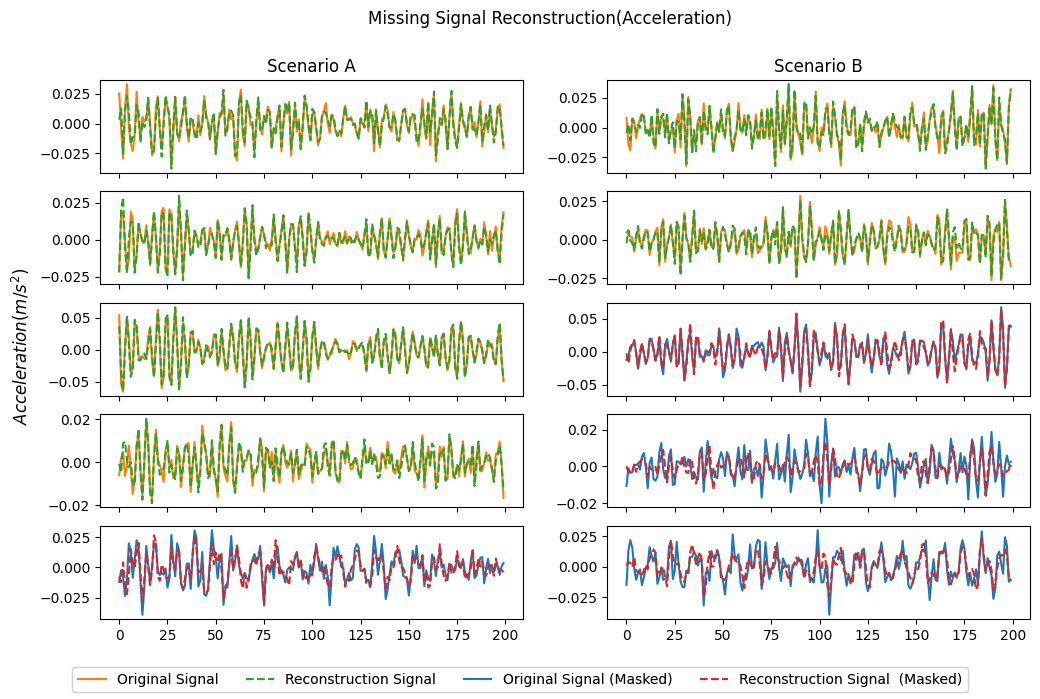

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(12,7), sharex=True)
visualize_masked_process_reconstructions(fig, axes[:,0], masked_signal, pretrain_prediction, original_signal, "A", r"$Displacement (m)$")
visualize_masked_process_reconstructions(fig, axes[:,1], masked_signal, pretrain_prediction, original_signal, "B", r"$Displacement (m)$")

fig.suptitle("Missing Signal Reconstruction(Acceleration)")
fig.supylabel(r"$Acceleration (m/s^2)$", x=0.05)

plt.savefig("./pic/Missing Reconstruction(accel).svg", bbox_inches="tight")
plt.savefig("./pic/Missing Reconstruction(accel).png", bbox_inches="tight", dpi=500)